## Introduction
The purpose of this notebook is to illustrate through the usage of an interface how autoencoded embeddings were generated in the dissertation project, clustered and analysed. Due to confidentiality reasons, the dataset used here is not the same as the one used in completion of the dissertation. Furthermore, it is more useful to have a small-sized dataset to speed up the illustration, and so the dataset used here is the Adult  Data Set, obtained form the University of California Irvine Machine Learning Repository [[1]](https://archive.ics.uci.edu/ml/datasets/Adult). It is composed of 48442 instances and 14 features intended to be used to predict whether an individual's income exceeds $50K. For convenience, a description of the features from [[1]]((https://archive.ics.uci.edu/ml/datasets/Adult)) has been copied and provided below. 

<div class="alert alert-block alert-info">
<ul>
<li> <b>age</b>: continuous. 
<li> <b>workclass</b>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
<li> <b>fnlwgt</b>: continuous. 
<li> <b>education</b>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th,  Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
<li> <b>education-num</b>: continuous. 
<li> <b>marital-status</b>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
<li> <b>occupation</b>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
<li> <b>relationship</b>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
<li> <b>race</b>: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
<li> <b>sex</b>: Female, Male. 
<li> <b>capital-gain</b>: continuous. 
<li> <b>capital-loss</b>: continuous. 
<li> <b>hours-per-week</b>: continuous.</li> 
<li> <b>native-country</b>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.</li>
</ul>
</div>


### Importing Packages
In this section the relevant packages and datasets are imported

In [1]:
import pandas as pd
from clusterlib.autoencoder import AutoEncoder
from clusterlib.famd import FAMDRecat
from sklearn.preprocessing import LabelEncoder

### Downloading the Dataset
In this section the dataset is combined, unneeded fields are dropped and categorical features are identified

In [2]:
adult_df = pd.read_csv('notebook_data/adult.csv')
adult_df.head()

,age,workclass,fnlweight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,weekly_hours,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [4]:
adult_df['income'] = adult_df['income'].map({' <=50K': 0, ' >50K': 1})
adult_df.rename(columns = {'income': 'high_income'}, inplace=True)
adult_df.head()

,age,workclass,fnlweight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,weekly_hours,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Generating AutoEncoded Embedding
In this section the autoencoder class used for analysis is created. There are within code descriptions to offer some clarity on the functionality. It should be noted that this code was not written for speed and robustness but for illustration purposes. Furthermore, in this implementation the vector size of categorical attributes is set to the smaller of the fourth root of the number of categories and 50. This is different from the implementation used in the dissertation where it was set to the smaller of half the number of categories and 50.   

The process of generating embeddings is shown for approach A, B and C, defined in Table 3 of the dissertation paper. 

### FAMD Principal Components
Prior to applying approaches A and B, principal components need to be created. In this section a quick exploration of the data is performed and the components are created. We note in the table that all features in the table have less than 50 categories and so recategorization will not be performed. Furthermore, it is noted that only 98 principal components is needed to fully account for the variance in the dataset

We begin by taking a look at the dataftypes of each feature to help with generating a list of numerical and categorical features

In [5]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlweight       32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  weekly_hours    32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  high_income     32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
# creating lists of numerical and categorical features
cat_features = adult_df.select_dtypes(exclude=['int64']).columns.tolist()
num_features = [col for col in adult_df.columns if col not in cat_features]
num_features.remove('high_income')

Next we review the number of unique attributes in each categorical feature to understand if there are features with high cardinality that should be recategorized. It is noted that none of the features have more than 50 unique categories.

Furthermore, a review of the total number of categories and numerical features is not very large. This suggests that there is little need for recategorizing as generating the principal components for this dataset would be fast. Recategorization would therefore not be performed.

In [7]:
# reviewing the size of each category 
adult_df[cat_features].nunique()

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
dtype: int64

In [8]:
# reviewing the total number of categories and numerical features
adult_df[cat_features].nunique().sum() + len(num_features)

108

Here Principal components are generated using the FAMD Recat Class. For simplicity the method for thorughness it is illustrated how the class would be used if recategorization were to be performed. However, the method for aggregation has no impact on the input dataset since none of the categorical features have less than 50 attributes.

In addition, based on the total number of categories and numerical features being 108, 100 principal components is estimated as a reasonable number that should capture all the variance.

In [9]:
# initializing the class
famd_recat = FAMDRecat(adult_df[cat_features + num_features], categorical_columns=cat_features)

# recategorizing categorical features with greater than 50 unique categories
famd_recat.aggregation_function(unique_attr_threshold=50)

# generating 100 principal components
famd_recat.get_principal_components(100)

The end time is 4.505753040313721


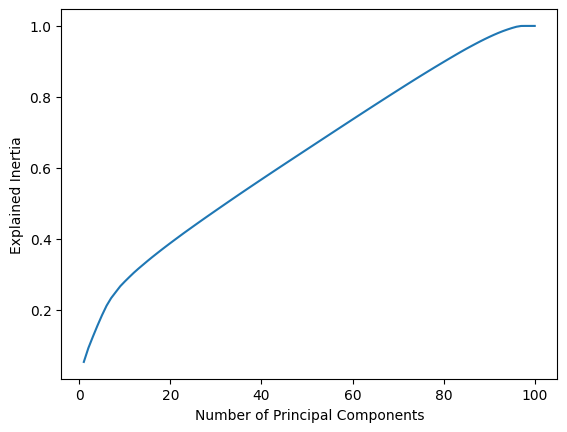

In [10]:
#  a plot of the inertia per added component is shown below
famd_recat.plot_explained_inertia()

In [11]:
# the generated principal components can be obtained from the class attribute famd_pc
famd_recat.famd_pc.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.707696,-1.085980,-0.852887,0.165609,-0.529963,-0.154967,0.158468,-0.007246,-0.142998,0.455687,...,-0.342903,0.079462,0.397356,-0.352798,-0.516158,0.367092,0.035059,0.009346,8.743559e-17,-1.905112e-16
1,0.807993,-0.127523,-1.768084,0.274963,0.377476,-0.252977,-1.616527,-0.706679,-0.275858,0.298867,...,-0.478757,0.356777,-0.232582,0.047535,0.081120,-0.019262,0.017413,-0.003370,2.552381e-16,-2.639830e-16
2,-0.517331,0.255015,0.265049,0.049193,-0.082959,-0.188252,0.433398,-0.174416,-0.432393,0.158299,...,-0.016189,0.083827,0.094976,0.389505,-0.128930,0.080945,-0.003899,0.000497,4.829632e-16,1.386835e-16
3,-0.541368,1.437521,0.381608,0.150076,0.336038,-0.100778,-0.424869,-0.367525,0.026724,-0.457815,...,-0.316710,0.304451,0.143531,-0.041681,0.168699,-0.291578,-0.004823,-0.000877,4.187519e-16,-4.480489e-16
4,0.281091,-1.303123,0.616566,0.155965,1.292839,-0.853666,0.235044,-0.403869,0.728259,0.022731,...,0.194354,0.120790,0.084495,0.388152,0.467930,0.542772,-0.047221,-0.014935,1.437356e-15,-2.207494e-16


### Approach A: FAMD to FAMD
As explained in the paper, this approach represents categorical features using FAMD principal components. 

In [12]:
approach_a = AutoEncoder(
    famd_recat.famd_pc.iloc[:, :98],
    categorical_columns=[],
    scale=False,
    learned_embedding=False
)

approach_a.build_autoencoder_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense (Dense)               (None, 500)               49500     
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 2000)              1002000   
                                                                 
 autencoded_embedding (Dense  (None, 2)                4002      
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 2000)              6000      
                                                           

Epoch 1/50


2022-09-20 01:18:49.432353: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


126/128 [============================>.] - ETA: 0s - loss: 0.2235 - mae: 0.2721
Epoch 1: loss improved from inf to 0.22345, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.2234 - mae: 0.2721
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.2022 - mae: 0.2545
Epoch 2: loss improved from 0.22345 to 0.20224, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 26ms/step - loss: 0.2022 - mae: 0.2545
Epoch 3/50
126/128 [============================>.] - ETA: 0s - loss: 0.1920 - mae: 0.2464
Epoch 3: loss improved from 0.20224 to 0.19165, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 7s 55ms/step - loss: 0.1917 - mae: 0.2463
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.1818 - mae: 0.2380
Epoch 4: loss improved from 0.19165 to 0.18178, saving mo

128/128 [==============================] - 3s 23ms/step - loss: 0.1036 - mae: 0.1896
Epoch 31/50
126/128 [============================>.] - ETA: 0s - loss: 0.1024 - mae: 0.1887
Epoch 31: loss improved from 0.10360 to 0.10233, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.1023 - mae: 0.1886
Epoch 32/50
127/128 [============================>.] - ETA: 0s - loss: 0.1037 - mae: 0.1903
Epoch 32: loss did not improve from 0.10233
128/128 [==============================] - 3s 23ms/step - loss: 0.1038 - mae: 0.1903
Epoch 33/50
127/128 [============================>.] - ETA: 0s - loss: 0.1065 - mae: 0.1919
Epoch 33: loss did not improve from 0.10233
128/128 [==============================] - 3s 23ms/step - loss: 0.1065 - mae: 0.1919
Epoch 34/50
127/128 [============================>.] - ETA: 0s - loss: 0.1041 - mae: 0.1909
Epoch 34: loss did not improve from 0.10233
128/128 [==============================] - 3s 

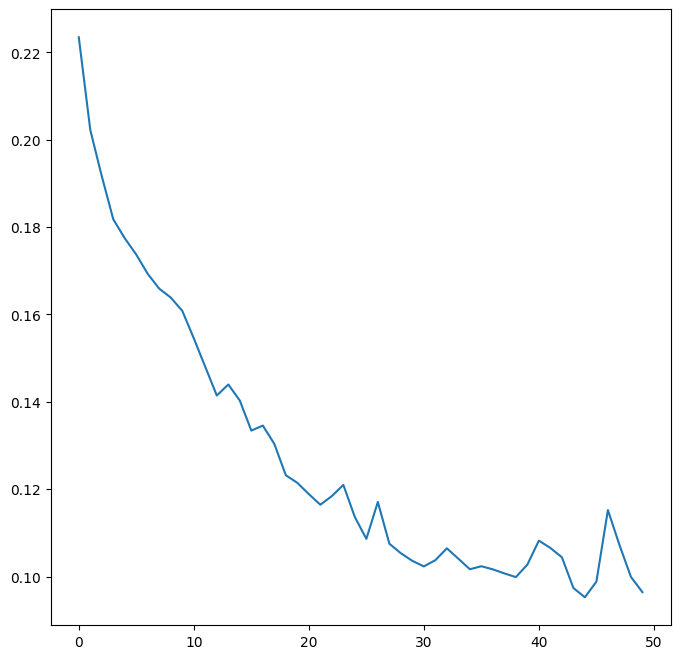

In [13]:
approach_a.fit_model(file_prefix='approach_a_', batch_size=256, epochs=50)

1018/1018 [==============================] - 2s 1ms/step


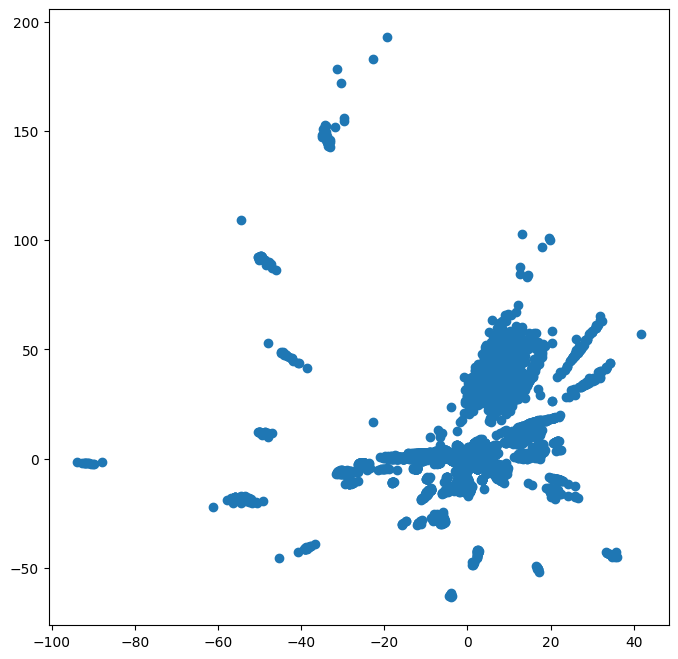

In [14]:
approach_a.extract_autoencoded_embedding()

### HDBSCAN clustering 

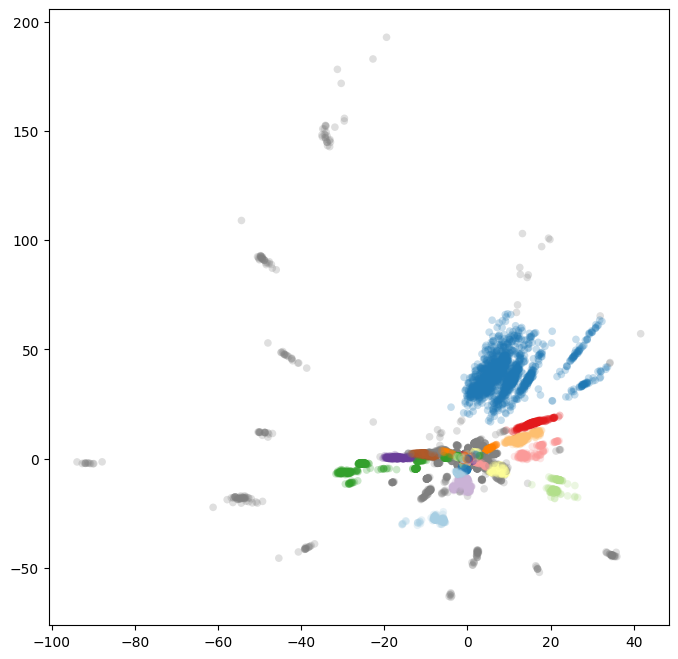

In [15]:
hdbscan_model_a = approach_a.hdbscan_clustering(min_cluster_size=150, min_samples=10)

In [16]:
approach_a.hdbscan_cluster_summary(hdbscan_model_a, adult_df, cat_features, sort_col='high_income')

,high_income,instance_count,age,fnlweight,education_num,capital_gain,capital_loss,weekly_hours,workclass,education,marital_status,occupation,relationship,race,sex,native_country
cluster_assignments,,,,,,,,,,,,,,,,
34,0.000000,400,25.397500,190956.075000,9.317500,65.710000,0.000000,36.275000,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,Male,United-States
38,0.005964,1006,24.915507,202012.585487,9.112326,168.685885,0.000000,34.120278,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States
39,0.008032,996,23.439759,165332.879518,9.937751,62.925703,0.000000,32.270080,Private,Some-college,Never-married,Other-service,Own-child,White,Female,United-States
15,0.008811,227,23.678414,191010.537445,8.000000,137.718062,0.000000,31.198238,Private,12th,Never-married,Other-service,Own-child,White,Male,United-States
11,0.012739,471,22.023355,188445.934183,7.000000,167.830149,0.000000,27.853503,Private,11th,Never-married,Other-service,Own-child,White,Male,United-States
19,0.014948,669,27.028401,184299.783259,9.998505,168.807175,0.000000,32.892377,?,Some-college,Never-married,?,Own-child,White,Female,United-States
40,0.016627,421,32.249406,187440.156770,9.339667,172.180523,0.767221,38.109264,Private,HS-grad,Never-married,Adm-clerical,Unmarried,White,Female,United-States
51,0.019937,953,29.810073,197853.193075,9.056663,187.806925,0.000000,38.214061,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
46,0.026915,483,41.217391,184171.399586,9.144928,160.074534,0.000000,38.066253,Private,HS-grad,Divorced,Adm-clerical,Unmarried,White,Female,United-States


In [17]:
approach_a.describe_approach_hdbscan(hdbscan_model_a, adult_df, 'weekly_hours', 'education_num')

{'feature': 'weekly_hours',
 'param_minclustersize': 150,
 'param_minsamples': 10,
 'min_cluster_size': 153,
 'min_mean_cluster_weekly_hours': 27.853503184713375,
 'max_mean_cluster_weekly_hours': 52.98406374501992,
 'percent_potentially_mergeable': 21.098772647574517,
 'multicluster_education_num_count': 15,
 'education_num_unique_attributes': 16,
 'multicluster_education_num_percent': 93.75}

### GMM clustering

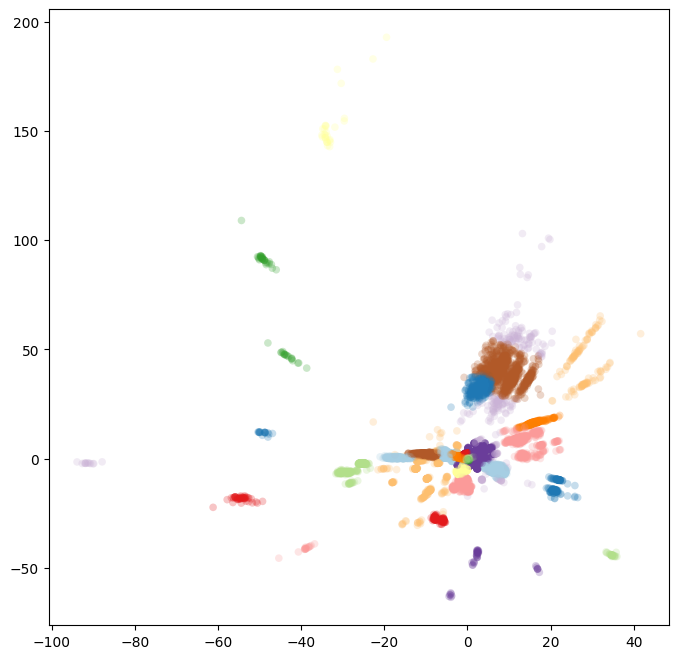

In [18]:
gmm_model_a = approach_a.gmm_clustering(n_components=30)

In [19]:
approach_a.gmm_cluster_summary(gmm_model_a, adult_df, cat_features, sort_col='high_income')

,high_income,instance_count,age,fnlweight,education_num,capital_gain,capital_loss,weekly_hours,workclass,education,marital_status,occupation,relationship,race,sex,native_country
cluster_assignments,,,,,,,,,,,,,,,,
5,0.000000,50,43.160000,235806.180000,1.000000,916.360000,67.820000,36.580000,Private,Preschool,Never-married,Other-service,Not-in-family,White,Male,"[ Mexico, United-States]"
23,0.010733,559,22.300537,195757.450805,7.000000,147.524150,0.000000,28.436494,Private,11th,Never-married,Other-service,Own-child,White,Male,United-States
19,0.017573,5975,28.145105,193588.982427,9.482343,171.465272,0.372552,35.939582,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States
0,0.027231,661,30.390318,211092.484115,9.338880,172.614221,2.854766,34.013616,?,12th,Never-married,?,Not-in-family,White,Female,United-States
17,0.036765,136,46.213235,243288.955882,2.000000,113.316176,19.139706,38.382353,Private,1st-4th,Married-civ-spouse,Other-service,Husband,White,Male,Mexico
24,0.041322,242,30.677686,288882.185950,8.743802,101.388430,1.731405,39.760331,Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,Mexico
14,0.043771,297,42.016835,237609.801347,3.000000,197.356902,0.000000,38.804714,Private,5th-6th,Married-civ-spouse,Other-service,Husband,White,Male,Mexico
4,0.062718,574,48.858885,185343.538328,4.000000,240.921603,0.000000,39.313589,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
3,0.064516,31,35.258065,274559.354839,9.354839,59.064516,59.612903,35.387097,Private,HS-grad,Never-married,Other-service,Own-child,White,Male,Peru


In [20]:
approach_a.describe_approach_gmm(gmm_model_a, adult_df, 'weekly_hours', 'education_num')

{'feature': 'weekly_hours',
 'param_components': 30,
 'param_num_init': 10,
 'min_cluster_size': 13,
 'min_mean_cluster_weekly_hours': 28.43649373881932,
 'max_mean_cluster_weekly_hours': 50.25454545454546,
 'percent_potentially_mergeable': 51.03448275862069,
 'multicluster_education_num_count': 16,
 'education_num_unique_attributes': 16,
 'multicluster_education_num_percent': 100.0}

{1: 463862.67515565705,
 2: 316167.0055701951,
 3: 302263.8581464104,
 4: 299063.8934913674,
 5: 292811.3677283167,
 6: 290243.8974076354,
 7: 284429.76638741395,
 8: 275575.12863715435,
 9: 281063.5822579489}

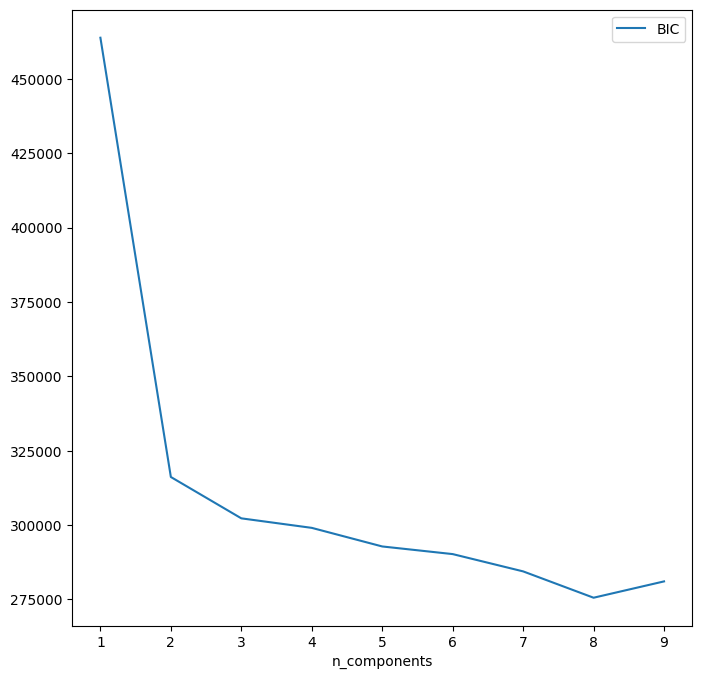

In [21]:
approach_a.gmm_bic_plot(components_list=list(range(1, 10)), n_init=5)

### Approach B: Learned Embeddings to FAMD Principal Components

In [ ]:
approach_b = AutoEncoder(
    adult_df[cat_features + num_features],
    output_data=famd_recat.famd_pc.iloc[:, :98],
    categorical_columns=cat_features,
)
approach_b.build_autoencoder_model()

In [ ]:
approach_b.fit_model(file_prefix='approach_b_')

In [ ]:
approach_b.extract_autoencoded_embedding()

### Approach C: Learned Embeddings to Nominal Encodings

In [ ]:
approach_c = AutoEncoder(
    adult_df[cat_features + num_features],
    categorical_columns=cat_features
)
approach_c.build_autoencoder_model()

In [ ]:
approach_c.fit_model(file_prefix='approach_c_')

In [ ]:
approach_c.extract_autoencoded_embedding()

### Approach D: Learned Embeddings to Nominal Encoding of the Occupation Feature


In [ ]:
output_d = adult_df[cat_features + num_features].copy()

# nominal encoding the occupation column
occupation_col = LabelEncoder().fit_transform(output_d['occupation'])

for col in output_d.columns:
    output_d[col] = occupation_col

In [ ]:
approach_d = AutoEncoder(
    adult_df[cat_features + num_features],
    output_data=output_d,
    categorical_columns=cat_features,
)
approach_d.build_autoencoder_model()


In [ ]:
approach_d.fit_model(file_prefix='approach_d_')

In [ ]:
approach_d.extract_autoencoded_embedding()

In [ ]:
hdbscan_model_d = approach_d.hdbscan_clustering(min_cluster_size=100)

In [ ]:
approach_d.hdbscan_cluster_summary(
    hdbscan_model=hdbscan_model_d, data=adult_df, cat_cols=cat_features, sort_col='high_income')

## References 
1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.